In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql
from datetime import datetime, timedelta, date
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
df = pd.read_csv('Test.csv - test.csv')

In [3]:
conn = sql.connect("sql.db") 

In [7]:
df.to_sql('bolt_task', conn)

4943

In [8]:
query ='''
with unique_orders as ( -- to filter out unique values 
        select
            distinct order_id_new   order_id 
        from bolt_task
        where prediction_price_type ='upfront' -- only upfront is analysed
            and b_state = 'finished'           -- only finished rides
            and change_reason_pricing is null 
            and upfront_price is not null
   ),
   
    applied_price_type as ( --to segment rides billed 
        select 
            odr.order_id,
            case
                when dt.upfront_price *1.2 < dt.metered_price then 'metered'
                when dt.upfront_price *0.8 > dt.metered_price then 'metered'
                else 'upfront' end applied_price_type                 
        from unique_orders odr
            left join bolt_task dt on odr.order_id = dt.order_id_new
        group by 1
    ),
    
    overpaid_ride_ticket as (
        select
            distinct order_id_new,
                     overpaid_ride_ticket       
    from bolt_task
        where overpaid_ride_ticket = '1'
    )
    
    select 
        pt.applied_price_type                            applied_price_type,
        pt.order_id                                      order_id,
        dt.distance/dt.predicted_distance-1              distance_diff,
        case when (
                dt.distance/dt.predicted_distance-1)<0
                    then 0
                    else 1  end                          distance_estimation, -- 1 for under predicted and 0 for over predicted
        dt.duration/dt.predicted_duration-1              duration_diff, 
        case when (
                dt.duration/dt.predicted_duration-1)<0
                    then 0
                    else 1 end                           duration_estimation, -- 1 for under predicted and 0 for over predicted      
        strftime('%H', calc_created)                     calc_hh,
        case
            when dt.entered_by = 'client' then 1
            else 0 end                                   entered_by,  -- 1 = client, 0 = driver,
        dt.gps_confidence                                gps_confidence,
        dt.dest_change_number                            dest_change_number,
        dt.rider_app_version                             rider_app_version,
        dt.driver_app_version                            driver_app_version,
        dt.eu_indicator                                  eu_indicator,
        case 
            when ovp.overpaid_ride_ticket 
                is null then 0 else 1 end                overpaid_ride_ticket,
        case 
            when dt.fraud_score is null
            then 0 else dt.fraud_score end               fraud_score
    from applied_price_type pt
        left join bolt_task dt on pt.order_id = dt.order_id_new
        left join overpaid_ride_ticket ovp on pt.order_id = ovp.order_id_new
    group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15

'''

In [9]:
df_data = pd.read_sql(query, conn)

In [10]:
df_data

,applied_price_type,order_id,distance_diff,distance_estimation,duration_diff,duration_estimation,calc_hh,entered_by,gps_confidence,dest_change_number,rider_app_version,driver_app_version,eu_indicator,overpaid_ride_ticket,fraud_score
0,metered,0,0.405115,1,1.487500,1,00,1,1,1,CA.5.42,DA.4.30,1,0,0.0
1,metered,1,-0.969534,0,-0.795045,0,00,1,1,1,CA.5.42,DA.4.34,1,0,-41.0
2,metered,6,0.432895,1,0.251374,1,00,1,1,1,CI.4.17,DA.4.37,1,0,-70.0
3,metered,7,0.632503,1,0.037927,1,01,1,1,1,CI.4.11,DI.3.33,1,0,-428.0
4,metered,9,1.050842,1,5.297229,1,01,1,0,1,CI.4.17,DA.4.10,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,upfront,4153,0.000731,1,-0.094828,0,22,1,1,1,CA.5.44,DA.4.23,1,0,-390.0
2914,upfront,4156,-0.128943,0,0.024448,1,23,1,1,1,CI.4.23,DI.3.39,1,0,0.0
2915,upfront,4157,-0.310865,0,-0.324324,0,22,1,1,1,CI.4.19,DA.4.31,1,0,-250.0
2916,upfront,4162,-0.100543,0,-0.104933,0,23,1,1,1,CI.4.19,DI.3.39,1,0,-154.0


In [12]:
counts = df_data.applied_price_type.value_counts()
percs = df_data.applied_price_type.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.concat([counts,percs], axis=1, keys=['count', 'percentage'])

,count,percentage
upfront,1595,54.7%
metered,1323,45.3%


In [13]:
df_fin = df_data.drop(columns =["order_id"])

In [19]:
df_fin.groupby('applied_price_type')[["distance_diff", "duration_diff","entered_by","gps_confidence","dest_change_number","eu_indicator", "overpaid_ride_ticket", "fraud_score"]].mean()

,distance_diff,duration_diff,entered_by,gps_confidence,dest_change_number,eu_indicator,overpaid_ride_ticket,fraud_score
applied_price_type,,,,,,,,
metered,0.371768,0.539182,0.979592,0.851096,1.068783,0.727891,0.049887,-417.794407
upfront,-0.023092,0.034469,0.986207,0.948589,1.038871,0.821944,0.019436,-412.800000


In [20]:
df_metered = df_fin[df_fin.applied_price_type=="metered"]

In [21]:
df_metered

,applied_price_type,distance_diff,distance_estimation,duration_diff,duration_estimation,calc_hh,entered_by,gps_confidence,dest_change_number,rider_app_version,driver_app_version,eu_indicator,overpaid_ride_ticket,fraud_score
0,metered,0.405115,1,1.487500,1,00,1,1,1,CA.5.42,DA.4.30,1,0,0.0
1,metered,-0.969534,0,-0.795045,0,00,1,1,1,CA.5.42,DA.4.34,1,0,-41.0
2,metered,0.432895,1,0.251374,1,00,1,1,1,CI.4.17,DA.4.37,1,0,-70.0
3,metered,0.632503,1,0.037927,1,01,1,1,1,CI.4.11,DI.3.33,1,0,-428.0
4,metered,1.050842,1,5.297229,1,01,1,0,1,CI.4.17,DA.4.10,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,metered,0.001496,1,0.269110,1,22,1,1,1,CI.4.19,DA.4.42,1,0,-7.0
1319,metered,-0.419781,0,-0.291667,0,22,1,1,1,CA.5.47,DA.4.31,1,0,0.0
1320,metered,0.311190,1,0.197464,1,23,1,1,1,CI.4.19,DA.4.42,1,0,-120.0
1321,metered,0.515419,1,0.353377,1,23,1,1,1,CA.5.47,DI.3.39,1,0,0.0


<AxesSubplot:>

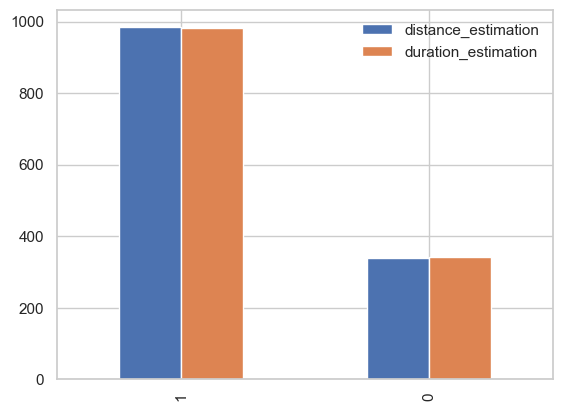

In [22]:
df_metered[['distance_estimation', 'duration_estimation']].apply(pd.Series.value_counts).plot(kind='bar')

In [24]:
counts = df_metered.distance_estimation.value_counts()
percs = df_metered.distance_estimation.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.concat([counts,percs], axis=1, keys=['count', 'percentage'])

,count,percentage
1,984,74.4%
0,339,25.6%


In [25]:
counts = df_metered.duration_estimation.value_counts()
percs = df_metered.duration_estimation.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.concat([counts,percs], axis=1, keys=['count', 'percentage'])

,count,percentage
1,982,74.2%
0,341,25.8%


In [34]:
df_metered_corr = df_metered[['distance_diff','distance_estimation','duration_diff','duration_estimation','gps_confidence', 'eu_indicator']]

In [35]:
df_metered_corr.corr()

,distance_diff,distance_estimation,duration_diff,duration_estimation,gps_confidence,eu_indicator
distance_diff,1.000000,0.297569,0.583964,0.251099,-0.162223,-0.000553
distance_estimation,0.297569,1.000000,0.354487,0.778332,-0.016918,0.181898
duration_diff,0.583964,0.354487,1.000000,0.425386,-0.151360,-0.068319
duration_estimation,0.251099,0.778332,0.425386,1.000000,0.015649,0.140605
gps_confidence,-0.162223,-0.016918,-0.151360,0.015649,1.000000,0.545756
eu_indicator,-0.000553,0.181898,-0.068319,0.140605,0.545756,1.000000


Text(0, 0.5, 'Frequency')

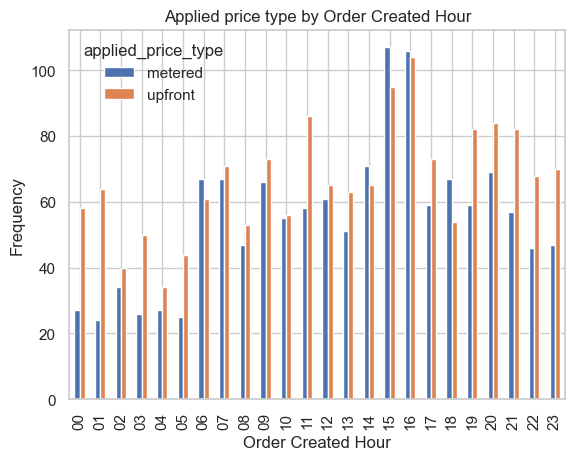

In [36]:
pd.crosstab(df_fin.calc_hh, df_fin.applied_price_type).plot(kind='bar')
plt.title('Applied price type by Order Created Hour')
plt.xlabel('Order Created Hour')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

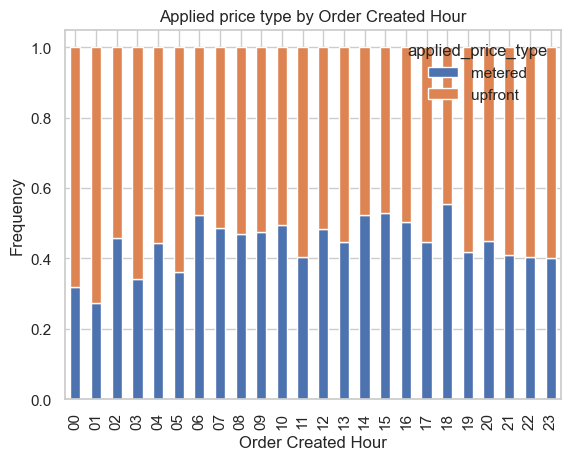

In [37]:
table = pd.crosstab(df_fin.calc_hh, df_fin.applied_price_type)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Applied price type by Order Created Hour')
plt.xlabel('Order Created Hour')
plt.ylabel('Frequency')

In [38]:
df_fin.calc_hh.value_counts()

16    210
15    202
20    153
11    144
19    141
21    139
09    139
07    138
14    136
17    132
06    128
12    126
18    121
23    117
13    114
22    114
10    111
08    100
01     88
00     85
03     76
02     74
05     69
04     61
Name: calc_hh, dtype: int64